In [27]:
%%javascript
require.config({ 
    paths: { 
    d3: 'https://d3js.org/d3.v7.min'
}});

require(["d3"], function(d3) {
    window.d3 = d3;
});

<IPython.core.display.Javascript object>

In [32]:
%reset -f
import sys
sys.path.append("/home/puneeth/UofT/SpARG Project/sparg2.0-manuscript/sparg2.0")
import sparg
import tskit
import msprime
import numpy as np
import tskit_arg_visualizer as viz
import warnings
import matplotlib.pyplot as plt
from importlib import reload

reload(sparg)
warnings.simplefilter("always")


# Variance in a lineage backwards in time

In [33]:
def ts_singlecompound(x=0.25, y=0.125, t=1 ):     
    ts_singlecompound = tskit.TableCollection(sequence_length=1e3)
    
    node_table = ts_singlecompound.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 0]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 4, 4, 5, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound.sort()
    return ts_singlecompound.tree_sequence()

def ts_stacked(x=0.25, n=1, seq_len = 1000 ):     
    ts_stacked = tskit.TableCollection(sequence_length=1e3)
    n_nodes = 3 + n*3
    # n_steps = 3 + 2*n 
    
    node_table = ts_stacked.nodes
    flag_list = np.zeros((n_nodes,))
    flag_list[0] = 1
    flag_list[1] = 1
    time_list = np.zeros((n_nodes,))
    time_list[-1] = (3 +2*n )*x
    
    for i in range(n):
        flag_list[2 +3*i] = 131072
        flag_list[2 +3*i + 1] = 131072
        time_list[2 +3*i] = (3 + 2*i)*x
        time_list[2 +3*i + 1] = (3 + 2*i)*x
        time_list[2 +3*i + 2] = (3 + 2*i + 1)*x
    
    node_table.set_columns(
        flags = np.array(flag_list, dtype=np.uint32),
        time = np.array(time_list),
        individual = np.array(list(range(2)) + [-1 for i in range(n_nodes-2)], dtype = np.int32)
    )
    
    individual_table = ts_stacked.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_stacked.edges
    
    seqlen = seq_len/float(n+1)
    child = [0,0,1]
    parent = [2,3,4]
    left = [ seqlen, 0, 0  ]
    right = [ (n+1)*seqlen, seqlen, (n+1)*seqlen ] 
    for i in range(n-1): 
        child += [ 2 + 3*i, 2+3*i, 2+3*i+1, 2+3*i+2 ]
        parent += [ 2 + 3*(i+1), 2+3*(i+1)+1, 2+3*i+2, 2+3*(i+1)+2 ]
        left += [(i+2)*seqlen , (i+1)*seqlen , i*seqlen , (i+1)*seqlen ]
        right += [(n+1)*seqlen , (i+2)*seqlen , (i+1)*seqlen  , (n+1)*seqlen ]
    child += [2+3*(n-1), 3*n, 3*n+1  ]
    parent += [2+3*n, 3*n+1, 3*n+2 ]
    left += [n*seqlen, (n-1)*seqlen, n*seqlen ]
    right += [(n+1)*seqlen, n*seqlen, (n+1)*seqlen]
    
    # print(child)
    # print(parent)
    # print(left)
    # print(right)
    
    edge_table.set_columns(
        left=np.array(left),
        right=np.array(right),
        parent=np.array(parent, dtype=np.int32),  # References IDs in the node table
        child=np.array(child, dtype=np.int32),  # References IDs in the node table
    )
    ts_stacked.sort()
    return ts_stacked.tree_sequence()


def ts_minimal_check(t=1): 
    
    ts_minimal_check = tskit.TableCollection(sequence_length = 1e3)

    node_table = ts_minimal_check.nodes
    node_table.add_row(flags=tskit.NODE_IS_SAMPLE, individual = 0)  # Node 0
    node_table.add_row(flags=tskit.NODE_IS_SAMPLE, individual = 1)  # Node 1
    node_table.add_row(flags=tskit.NODE_IS_SAMPLE, individual = 2)  # Node 2
    node_table.add_row(time=t, flags=msprime.NODE_IS_RE_EVENT)  # Node 3
    node_table.add_row(time=t, flags=msprime.NODE_IS_RE_EVENT) # Node 4 
    node_table.add_row(time=2*t)  # Node 5
    node_table.add_row(time=3*t)  # Node 6
    node_table.add_row(time=4*t, flags=msprime.NODE_IS_RE_EVENT)  # Node 7
    node_table.add_row(time=4*t, flags=msprime.NODE_IS_RE_EVENT)  # Node 8
    node_table.add_row(time=5*t)  # Node 9
    node_table.add_row(time=6*t)  # Node 10

    edge_table = ts_minimal_check.edges
    edge_table.add_row(left=0, right=500, parent=3, child=0)
    edge_table.add_row(left=500, right=1e3, parent=4, child=0)
    edge_table.add_row(left=0, right=1e3, parent=5, child=1)
    edge_table.add_row(left=0, right=1e3, parent=9, child=2)
    edge_table.add_row(left=0, right=500, parent=5, child=3)
    edge_table.add_row(left=500, right=1e3, parent=6, child=4)
    edge_table.add_row(left=0, right=1e3, parent=6, child=5)
    edge_table.add_row(left=0, right=700, parent=7, child=6)
    edge_table.add_row(left=700, right=1e3, parent=8, child=6)
    edge_table.add_row(left=0, right=700, parent=9, child=7)
    edge_table.add_row(left=700, right=1e3, parent=10, child=8)
    edge_table.add_row(left=0, right=1e3, parent=10, child=9)

    individuals_table = ts_minimal_check.individuals 
    individuals_table.add_row(flags = 0)
    individuals_table.add_row(flags = 0)
    individuals_table.add_row(flags = 0)
    
    ts_minimal_check.sort()
    return ts_minimal_check.tree_sequence()

ts = ts_minimal_check()
print(ts.draw_text())


6.00┊  10   ┊  10   ┊  10   ┊  
    ┊   ┃   ┊   ┃   ┊  ┏┻━┓ ┊  
5.00┊   9   ┊   9   ┊  ┃  9 ┊  
    ┊  ┏┻━┓ ┊  ┏┻━┓ ┊  ┃  ┃ ┊  
4.00┊  7  ┃ ┊  7  ┃ ┊  8  ┃ ┊  
    ┊  ┃  ┃ ┊  ┃  ┃ ┊  ┃  ┃ ┊  
3.00┊  6  ┃ ┊  6  ┃ ┊  6  ┃ ┊  
    ┊  ┃  ┃ ┊ ┏┻┓ ┃ ┊ ┏┻┓ ┃ ┊  
2.00┊  5  ┃ ┊ ┃ 5 ┃ ┊ ┃ 5 ┃ ┊  
    ┊ ┏┻┓ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊  
1.00┊ 3 ┃ ┃ ┊ 4 ┃ ┃ ┊ 4 ┃ ┃ ┊  
    ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊  
0.00┊ 0 1 2 ┊ 0 1 2 ┊ 0 1 2 ┊  
    0      500     700    1000 



In [81]:
from matplotlib.lines import Line2D

def locate_nodes(nodes, SpARG):
    """Calculate the location of the list of nodes

    Parameters
    ----------
    nodes : list
        List of nodes for which the locations will be calculated
    SpARG : SpatialARG
    	An instance of the SpatialARG class defined below. 

    Returns
    -------
    node_locations : dict
        The keys are the nodes. The values are the geographic location of the nodes in n dimensions
    variance_in_node_locations : dict
        The keys are the nodes. The values are the variance in the geographic location of the nodes in n dimensions
    """

    sigma = SpARG.dispersal_rate_matrix
    paths = SpARG.paths
    inverted_cov_mat = SpARG.inverted_paths_shared_time_matrix
    sample_locs_to_root_locs = SpARG.path_dispersal_distances
    root_locations = SpARG.root_locations
    node_shared_times = SpARG.node_paths_shared_times
    node_paths = SpARG.node_paths
    ts = SpARG.ts
    
    location_of_nodes = {} 
    variance_in_node_locations = {} 
    
    for i,node in enumerate(nodes): 
        node_specific_sharing = node_shared_times[node,:].copy()
        matmul_prod = np.matmul(node_specific_sharing, inverted_cov_mat)
        root_location = root_locations[node_paths[node][-1]]
        node_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
        location_of_nodes[node] = node_location
        
        base_variance = np.matmul(matmul_prod, np.transpose(node_specific_sharing))
        ones = np.ones(inverted_cov_mat.shape[0])
        correction_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
        correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
        corrected_variance_scaling_factor = (ts.max_root_time-ts.node(node).time)-base_variance+(correction_numerator/correction_denominator)
        total_variance_node = sigma*corrected_variance_scaling_factor
        variance_in_node_locations[node] = total_variance_node
    return location_of_nodes, variance_in_node_locations


def track_lineage(ts, path, intervals=100 ,variance_decomposition = False): 
    tsARG = sparg.SpatialARG(ts=ts, dimensions=2, verbose=False)
    locations_of_nodes, var_nodes = locate_nodes(nodes = path, SpARG = tsARG)
    inverted_cov_mat = tsARG.inverted_paths_shared_time_matrix
    paths = tsARG.paths
    node_shared_times = tsARG.node_paths_shared_times 
    
    edge_pairs = {}
    
    for node in ts.nodes():
        node_parents = np.unique(ts.tables.edges.parent[np.where(ts.tables.edges.child == node.id)[0]])
        if len(node_parents)==2: 
            edge_pairs[node_parents[0]] = [node.id,node_parents[1]]
            edge_pairs[node_parents[1]] = [node.id,node_parents[0]]
    
    paths_edges = []
    for pth in paths: 
        path_edges = np.column_stack([pth[:-1],pth[1:]])
        path_edge_pairs = list(map(edge_pairs.get, list(set(pth).intersection(set(edge_pairs.keys())))))
        if len(path_edge_pairs) > 0: 
            path_edges = np.append(path_edges, path_edge_pairs, axis = 0)
        paths_edges += [path_edges]
    
    interval = (ts.tables.nodes.time[path[-1]] - ts.tables.nodes.time[path[0]])/intervals
    node_times = []
    node_locations = []
    node_location_variance_total = [] 
    node_location_variance_uncorrected = [] 
    node_location_variance_correction = [] 
    
    ones = np.ones(inverted_cov_mat.shape[0])
    correction_denominator = np.matmul(np.matmul(np.transpose(ones), inverted_cov_mat), ones)
    
    for i in range(len(path) - 1):
        node = path[i]
        node_time = ts.tables.nodes.time[node] 
        node_location = np.array(locations_of_nodes[node])
        
        nxt_node = path[i+1]
        nxt_node_time = ts.tables.nodes.time[nxt_node]
        nxt_node_location = np.array(locations_of_nodes[nxt_node])
        
        edge_in_path = np.array([ 1 if np.any(np.all([node, nxt_node] == path_edges, axis=1)) else 0 for path_edges in paths_edges ])
        for tm in list(np.arange(node_time, nxt_node_time, interval)) + [nxt_node_time]: 
            
            node_times += [tm]
            start_node_sharing = node_shared_times[node,:]
            end_node_sharing = node_shared_times[path[i+1],:]
            x = (tm-node_time)/(nxt_node_time - node_time)

            node_specific_sharing = end_node_sharing + (1-x)*(nxt_node_time - node_time)*edge_in_path
            #print(node_location, nxt_node_location)
            node_locations += [(1-x)*np.array(node_location) + x*nxt_node_location]
            #node_specific_sharing = end_node_sharing + x*(nxt_node_time-node_time)*edge_in_path
            #print(np.round(x,2), tm, node_specific_sharing, start_node_sharing, end_node_sharing, edge_in_path)
            
            uncorrected_variance = ts.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing, inverted_cov_mat), np.transpose(node_specific_sharing))
            node_location_variance_uncorrected += [uncorrected_variance]

            correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
            correction = correction_numerator/correction_denominator 
            node_location_variance_correction += [correction,10]       

            corrected_variance_scaling_factor = np.round(uncorrected_variance + correction,10)
            node_location_variance_total += [corrected_variance_scaling_factor]
            if corrected_variance_scaling_factor < 0:
                print(node,nxt_node, node_time, nxt_node_time, x, tm, ts.max_root_time, np.matmul(np.matmul(node_specific_sharing, inverted_cov_mat), np.transpose(node_specific_sharing)))
                print(uncorrected_variance, correction, corrected_variance_scaling_factor)
                raise RunTimeError("Negative Variance")
    if variance_decomposition: 
        return node_times, node_locations, node_location_variance_total, node_location_variance_uncorrected, node_location_variance_correction
    else: 
        return node_times, node_locations, node_location_variance_total


def track_single_lineage(ts, ts_tree, path_list):
    tsARG = sparg.SpatialARG(ts=ts, dimensions=2, verbose=False)
    locations_of_nodes, corrected_variances = locate_nodes(nodes = path, SpARG=tsARG)
    inverted_cov_mat = tsARG.inverted_paths_shared_time_matrix
    paths = tsARG.paths
    node_shared_times = tsARG.node_paths_shared_times 
    
    treeARG = sparg.SpatialARG(ts=ts_tree, dimensions=2, verbose=False)
    locations_of_nodes_tree, corrected_variances_tree = locate_nodes(nodes = path, SpARG=treeARG)
    inverted_cov_mat_tree = treeARG.inverted_paths_shared_time_matrix
    paths_tree = treeARG.paths
    node_shared_times_tree = treeARG.node_paths_shared_times 
    
    edge_pairs = {}
    
    for node in ts.nodes():
        node_parents = np.unique(ts.tables.edges.parent[np.where(ts.tables.edges.child == node.id)[0]])
        if len(node_parents)==2: 
            edge_pairs[node_parents[0]] = [node.id,node_parents[1]]
            edge_pairs[node_parents[1]] = [node.id,node_parents[0]]
    
    paths_edges = []
    for pth in paths: 
        path_edges = np.column_stack([pth[:-1],pth[1:]])
        path_edge_pairs = list(map(edge_pairs.get, list(set(pth).intersection(set(edge_pairs.keys())))))
        if len(path_edge_pairs) > 0: 
            path_edges = np.append(path_edges, path_edge_pairs, axis = 0)
        paths_edges += [path_edges]
    
    paths_edges_tree = [np.column_stack([pth[:-1],pth[1:]]) for pth in paths_tree ]
    #print(paths_tree, paths_edges_tree)
    
    interval = (ts.tables.nodes.time[path[-1]] - ts.tables.nodes.time[path[0]])/100
    node_times = []
    node_location_variance_total = [] 
    node_location_variance_total_tree = [] 

    node_location_variance_uncorrected = [] 
    node_location_variance_uncorrected_tree = [] 

    node_location_variance_correction = [] 
    node_location_variance_correction_tree = [] 


    ones = np.ones(inverted_cov_mat.shape[0])
    correction_denominator = np.matmul(np.matmul(np.transpose(ones), inverted_cov_mat), ones)
    ones_tree = np.ones(inverted_cov_mat_tree.shape[0])
    correction_denominator_tree = np.matmul(np.matmul(np.transpose(ones_tree),inverted_cov_mat_tree),ones_tree)

    for i in range(len(path) - 1):
        node = path[i]
        node_time = ts.tables.nodes.time[node] 
        nxt_node = path[i+1]
        nxt_node_time = ts.tables.nodes.time[nxt_node]
        edge_in_path = np.array([ 1 if np.any(np.all([node, nxt_node] == path_edges, axis=1)) else 0 for path_edges in paths_edges ])
        edge_in_path_tree = np.array([ 1 if np.any(np.all([node, nxt_node] == path_edges_tree, axis=1)) else 0 for path_edges_tree in paths_edges_tree ])
        #print("new",node_time, nxt_node_time, "nodes", node, nxt_node)
        for tm in np.arange(node_time, nxt_node_time, interval ): 
            
            node_times += [tm]
            start_node_sharing = node_shared_times[node,:]
            end_node_sharing = node_shared_times[path[i+1],:]
            x = (tm-node_time)/(nxt_node_time - node_time)

            node_specific_sharing = end_node_sharing + (1-x)*(nxt_node_time - node_time)*edge_in_path
            #node_specific_sharing = end_node_sharing + x*(nxt_node_time-node_time)*edge_in_path
            #print(np.round(x,2), tm, node_specific_sharing, start_node_sharing, end_node_sharing, edge_in_path)
            
            uncorrected_variance = ts.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing, inverted_cov_mat), np.transpose(node_specific_sharing))
            node_location_variance_uncorrected += [uncorrected_variance]

            correction_numerator = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing),inverted_cov_mat),ones))**2
            correction = correction_numerator/correction_denominator 
            node_location_variance_correction += [correction]       

            corrected_variance_scaling_factor = uncorrected_variance + correction 
            node_location_variance_total += [corrected_variance_scaling_factor]
            
            start_node_sharing_tree = node_shared_times_tree[node,:]
            end_node_sharing_tree = node_shared_times_tree[path[i+1],:]

            node_specific_sharing_tree = end_node_sharing_tree + (1-x)*(nxt_node_time-node_time)*edge_in_path_tree
            #node_specific_sharing_tree = end_node_sharing_tree + x*(nxt_node_time-node_time)*edge_in_path_tree
            #print(np.round(x,2), tm, node_specific_sharing_tree, start_node_sharing_tree, end_node_sharing_tree, edge_in_path_tree)

            uncorrected_variance_tree = ts_tree.max_root_time - tm - np.matmul(np.matmul(node_specific_sharing_tree, inverted_cov_mat_tree), np.transpose(node_specific_sharing_tree))
            node_location_variance_uncorrected_tree += [uncorrected_variance_tree]

            correction_numerator_tree = (1-np.matmul(np.matmul(np.transpose(node_specific_sharing_tree),inverted_cov_mat_tree),ones_tree))**2
            correction_tree = correction_numerator_tree/correction_denominator_tree
            node_location_variance_correction_tree += [correction_tree]

            corrected_variance_scaling_factor_tree = uncorrected_variance_tree + correction_tree
            node_location_variance_total_tree += [corrected_variance_scaling_factor_tree]

    plt.figure()    
    plt.plot(node_times, node_location_variance_total, label="ARG", linewidth = 3)
    plt.plot(node_times, node_location_variance_total_tree, label="Tree", linewidth = 3)
    plt.xlabel("Time", fontsize = 20)
    plt.ylabel("Total Variance in Location", fontsize = 20)
    for nd in path: 
        child = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd)[0]] 
        if len(child) > 1 or nd in ts.samples() : 
            plt.axvline(x=ts.tables.nodes.time[nd], color = 'grey', linewidth = 1.5)
        else:
            plt.axvline(x=ts.tables.nodes.time[nd], color = 'grey', linestyle = "--", linewidth = 1.5)
    
    recomb_line = Line2D([0], [0], label='Recombination Node', color='grey', linestyle = "--")
    coal_line = Line2D([0], [0], label='Coalescent Node', color='grey')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([recomb_line,coal_line])
    plt.legend(handles=handles, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show() 

    plt.figure()
    plt.plot(node_times, node_location_variance_uncorrected, label="ARG")
    plt.plot(node_times, node_location_variance_uncorrected_tree, label="Tree")
    plt.xlabel("Time", fontsize = 15)
    plt.ylabel("Uncorrected Variance in Location", fontsize = 15)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(node_times, node_location_variance_correction, label="ARG")
    plt.plot(node_times, node_location_variance_correction_tree, label="Tree")
    plt.xlabel("Time")
    plt.ylabel("Correction Variance in Location")
    plt.legend()
    plt.show()
     
    return 0



# Figure 4

In [82]:

%matplotlib qt
ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_nodes = ts_tables.nodes 
ts_nodes.time = [0,0,0.25,0.25,0.5,0.75,0.75,1,1.25,1.25,1.5,1.75]
ts_tables.sort() 
ts = ts_tables.tree_sequence()

viz.D3ARG(ts=ts).draw(edge_type="ortho")

ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:3]]), simplify=False).trim()
print(ts_tree.draw_text())
interval = (ts.tables.nodes.time[2] - ts.tables.nodes.time[0])/5000.0

for path in [[3,4],[5,9,10],[8,11],[1,4,7]]:
    print(path)
    intervals = (ts.tables.nodes.time[path[-1]] - ts.tables.nodes.time[path[0]])/interval
    node_times, node_locations, node_variance = track_lineage(ts, path, intervals=intervals) 
    #print(np.transpose(node_locations)[0],node_times,node_variance)
    plt.plot(np.transpose(node_locations)[0],node_times,color='black',linewidth =5 )
    #markers, caps, bars = plt.errorbar(x = np.transpose(node_locations)[0],y = node_times, xerr=0.5*np.sqrt(node_variance), ecolor='lightgrey',elinewidth=1, color = 'black', linewidth = 5)
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    

path = [0,2,6,7,10,11]
node_times, node_locations, node_variance = track_lineage(ts, path, intervals=1000) 
markers, caps, bars = plt.errorbar(x = np.transpose(node_locations)[0],y = node_times, xerr=0.5*np.sqrt(node_variance), ecolor='cyan',elinewidth=1, color = 'blue',linewidth =5 )
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

plt.show()
plt.xlabel("Location", fontsize=28) 
plt.ylabel("Time", fontsize=28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()


ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_tables.sort() 
ts = ts_tables.tree_sequence()
ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:3]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [0,2,6,7,10,11]
track_single_lineage(ts, ts_tree, path)




/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:37: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.js' mode='r' encoding='UTF-8'>
  main_text_template = Template(open(os.path.dirname(__file__) + "/visualizer.js", "r").read())
/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:40: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.css' mode='r' encoding='UTF-8'>
  styles = open(os.path.dirname(__file__) + "/visualizer.css", "r").read()


1.75┊ 11  ┊ 
    ┊  ┃  ┊ 
1.50┊ 10  ┊ 
    ┊  ┃  ┊ 
1.25┊  ┃  ┊ 
    ┊  ┃  ┊ 
1.00┊  7  ┊ 
    ┊ ┏┻┓ ┊ 
0.75┊ 6 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.50┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
0.25┊ 2 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    250

[3, 4]
[5, 9, 10]
[8, 11]
[1, 4, 7]
2.25┊ 11  ┊ 
    ┊  ┃  ┊ 
2.00┊ 10  ┊ 
    ┊  ┃  ┊ 
1.75┊  ┃  ┊ 
    ┊  ┃  ┊ 
1.50┊  7  ┊ 
    ┊ ┏┻┓ ┊ 
1.25┊ 6 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
1.00┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
0.75┊ 2 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    250



0

# Other Examples 

2.25┊ 11  ┊ 11  ┊ 11  ┊ 11  ┊  
    ┊  ┃  ┊  ┃  ┊  ┃  ┊ ┏┻┓ ┊  
2.00┊ 10  ┊ 10  ┊ 10  ┊ ┃10 ┊  
    ┊  ┃  ┊  ┃  ┊ ┏┻┓ ┊ ┃ ┃ ┊  
1.75┊  ┃  ┊  ┃  ┊ 9 ┃ ┊ 8 ┃ ┊  
    ┊  ┃  ┊  ┃  ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.50┊  7  ┊  7  ┊ ┃ 7 ┊ ┃ 7 ┊  
    ┊  ┃  ┊ ┏┻┓ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.25┊  ┃  ┊ 6 ┃ ┊ 5 ┃ ┊ 5 ┃ ┊  
    ┊  ┃  ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.00┊  4  ┊ ┃ 4 ┊ ┃ 4 ┊ ┃ 4 ┊  
    ┊ ┏┻┓ ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.75┊ 3 ┃ ┊ 2 ┃ ┊ 2 ┃ ┊ 2 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊ 0 1 ┊ 0 1 ┊  
    0    250   500   750  1000 



/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:37: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.js' mode='r' encoding='UTF-8'>
  main_text_template = Template(open(os.path.dirname(__file__) + "/visualizer.js", "r").read())
/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:40: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.css' mode='r' encoding='UTF-8'>
  styles = open(os.path.dirname(__file__) + "/visualizer.css", "r").read()


/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:37: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.js' mode='r' encoding='UTF-8'>
  main_text_template = Template(open(os.path.dirname(__file__) + "/visualizer.js", "r").read())
/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:40: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.css' mode='r' encoding='UTF-8'>
  styles = open(os.path.dirname(__file__) + "/visualizer.css", "r").read()


2.00┊  5  ┊  5  ┊  
    ┊  ┃  ┊ ┏┻┓ ┊  
1.75┊  4  ┊ ┃ 4 ┊  
    ┊ ┏┻┓ ┊ ┃ ┃ ┊  
1.50┊ 2 ┃ ┊ 3 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊  
    0    500  1000 



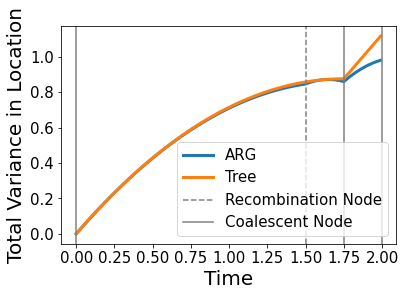

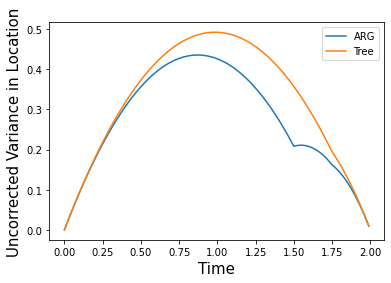

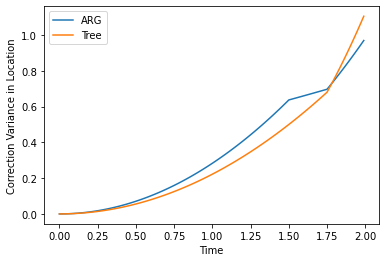

2.00┊  5  ┊ 
    ┊ ┏┻┓ ┊ 
1.75┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
1.50┊ 3 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    500



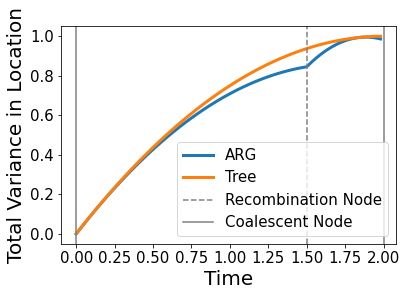

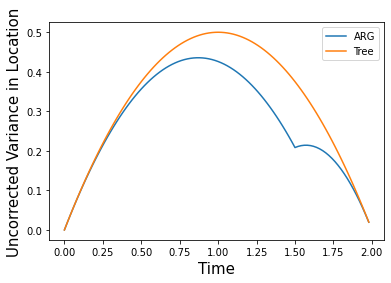

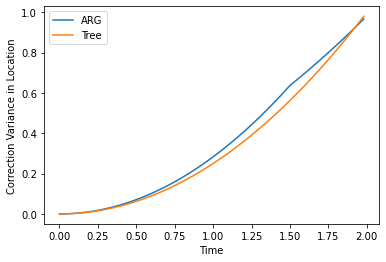

2.00┊  5  ┊ 
    ┊  ┃  ┊ 
1.75┊  4  ┊ 
    ┊ ┏┻┓ ┊ 
1.50┊ 2 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    500



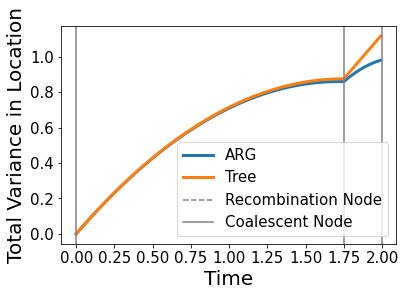

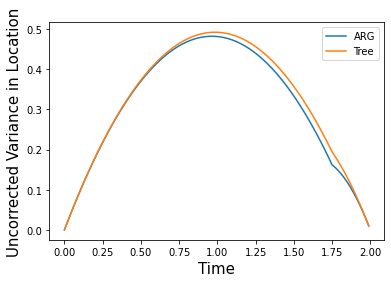

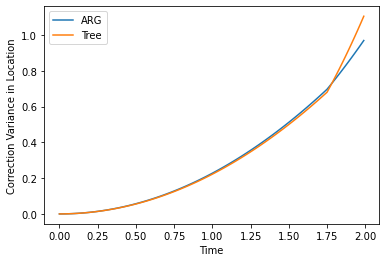

2.00┊  5  ┊ 
    ┊ ┏┻┓ ┊ 
1.75┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
1.50┊ 3 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    500



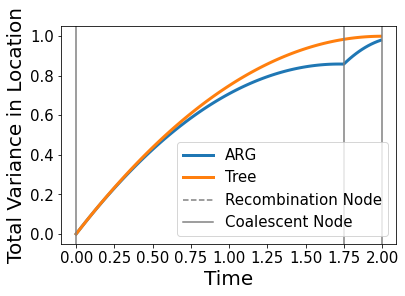

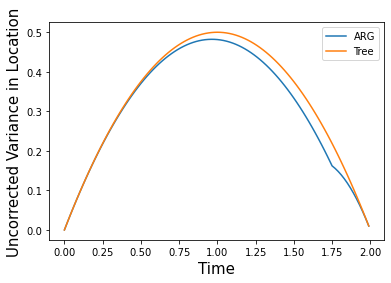

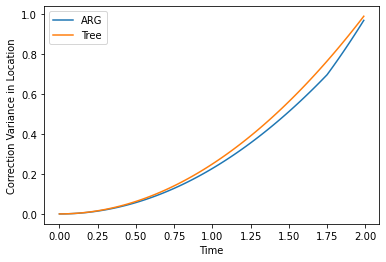

0

In [41]:
%matplotlib inline

ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_tables.sort() 
ts = ts_tables.tree_sequence()

%matplotlib inline

print(ts.draw_text())
viz.D3ARG(ts=ts).draw(edge_type="ortho")
ts = ts_singlecompound(t=2)
ts.keep_intervals?
ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[:2]]), simplify=False).trim()
viz.D3ARG(ts=ts).draw(edge_type="ortho")
print(ts.draw_text())
path = [0,2,4,5]
track_single_lineage(ts, ts_tree, path)


ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [0,3,5]
track_single_lineage(ts, ts_tree, path)

ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[:2]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [1,4,5]
track_single_lineage(ts, ts_tree, path)

ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [1,4,5]
track_single_lineage(ts, ts_tree, path)


2.25┊ 11  ┊ 11  ┊ 11  ┊ 11  ┊  
    ┊  ┃  ┊  ┃  ┊  ┃  ┊ ┏┻┓ ┊  
2.00┊ 10  ┊ 10  ┊ 10  ┊ ┃10 ┊  
    ┊  ┃  ┊  ┃  ┊ ┏┻┓ ┊ ┃ ┃ ┊  
1.75┊  ┃  ┊  ┃  ┊ 9 ┃ ┊ 8 ┃ ┊  
    ┊  ┃  ┊  ┃  ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.50┊  7  ┊  7  ┊ ┃ 7 ┊ ┃ 7 ┊  
    ┊  ┃  ┊ ┏┻┓ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.25┊  ┃  ┊ 6 ┃ ┊ 5 ┃ ┊ 5 ┃ ┊  
    ┊  ┃  ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
1.00┊  4  ┊ ┃ 4 ┊ ┃ 4 ┊ ┃ 4 ┊  
    ┊ ┏┻┓ ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.75┊ 3 ┃ ┊ 2 ┃ ┊ 2 ┃ ┊ 2 ┃ ┊  
    ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊ ┃ ┃ ┊  
0.00┊ 0 1 ┊ 0 1 ┊ 0 1 ┊ 0 1 ┊  
    0    250   500   750  1000 



/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:37: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.js' mode='r' encoding='UTF-8'>
  main_text_template = Template(open(os.path.dirname(__file__) + "/visualizer.js", "r").read())
/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/__init__.py:40: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/puneeth/anaconda3/lib/python3.9/site-packages/tskit_arg_visualizer/visualizer.css' mode='r' encoding='UTF-8'>
  styles = open(os.path.dirname(__file__) + "/visualizer.css", "r").read()


2.25┊ 11  ┊ 
    ┊  ┃  ┊ 
2.00┊ 10  ┊ 
    ┊  ┃  ┊ 
1.75┊  ┃  ┊ 
    ┊  ┃  ┊ 
1.50┊  7  ┊ 
    ┊  ┃  ┊ 
1.25┊  ┃  ┊ 
    ┊  ┃  ┊ 
1.00┊  4  ┊ 
    ┊ ┏┻┓ ┊ 
0.75┊ 3 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    250



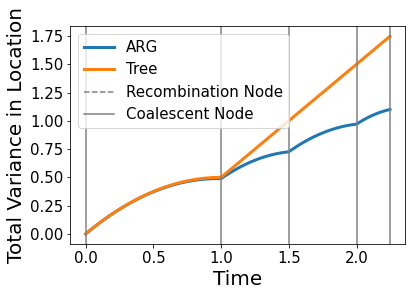

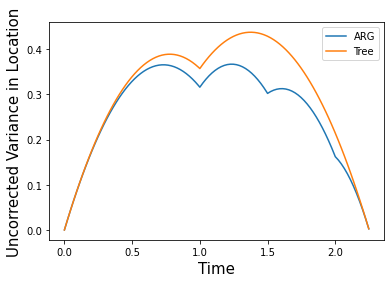

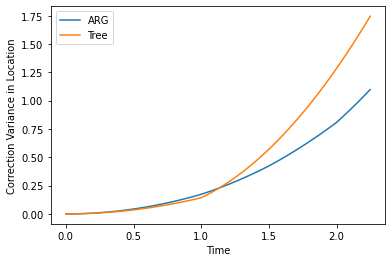

2.25┊ 11  ┊ 
    ┊  ┃  ┊ 
2.00┊ 10  ┊ 
    ┊  ┃  ┊ 
1.75┊  ┃  ┊ 
    ┊  ┃  ┊ 
1.50┊  7  ┊ 
    ┊ ┏┻┓ ┊ 
1.25┊ 6 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
1.00┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
0.75┊ 2 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    250



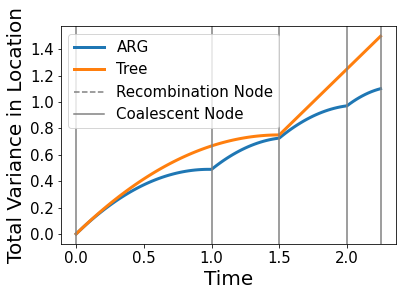

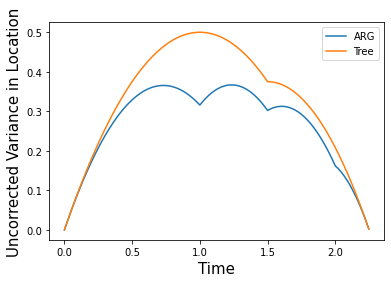

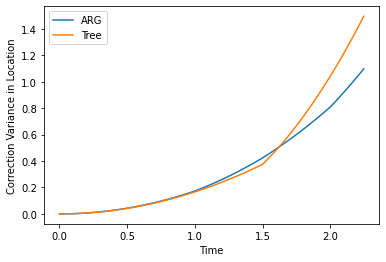

2.25┊ 11  ┊ 
    ┊  ┃  ┊ 
2.00┊ 10  ┊ 
    ┊ ┏┻┓ ┊ 
1.75┊ 9 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
1.50┊ ┃ 7 ┊ 
    ┊ ┃ ┃ ┊ 
1.25┊ 5 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
1.00┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
0.75┊ 2 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    250



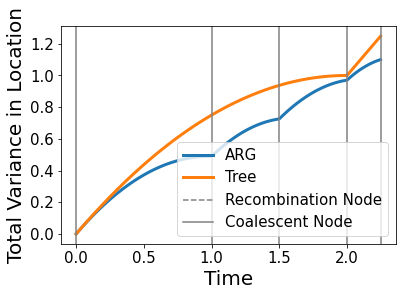

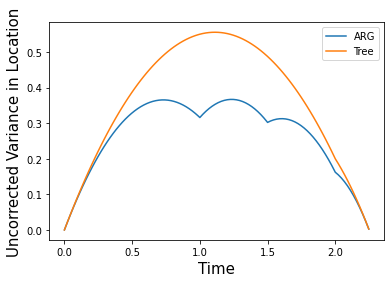

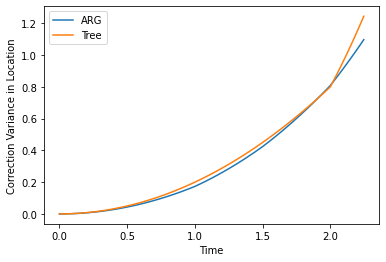

2.25┊ 11  ┊ 
    ┊ ┏┻┓ ┊ 
2.00┊ ┃10 ┊ 
    ┊ ┃ ┃ ┊ 
1.75┊ 8 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
1.50┊ ┃ 7 ┊ 
    ┊ ┃ ┃ ┊ 
1.25┊ 5 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
1.00┊ ┃ 4 ┊ 
    ┊ ┃ ┃ ┊ 
0.75┊ 2 ┃ ┊ 
    ┊ ┃ ┃ ┊ 
0.00┊ 0 1 ┊ 
    0    250



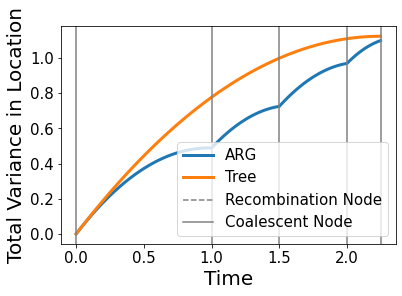

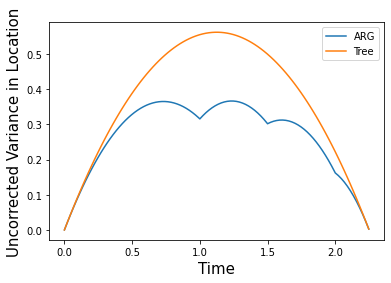

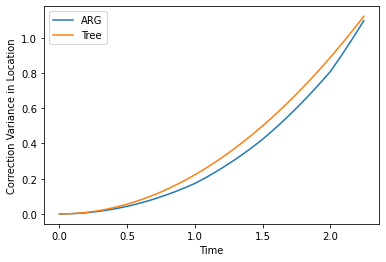

0

In [42]:
ts = ts_stacked(n=3)
ts_tables = ts.dump_tables() 
ts_edges = ts_tables.edges
ts_edges.left = [250, 0, 0, 0, 500, 250, 0, 250, 750, 500, 0, 500, 750, 0]
ts_tables.sort() 
ts = ts_tables.tree_sequence()

%matplotlib inline

print(ts.draw_text())
viz.D3ARG(ts=ts).draw(edge_type="ortho")


ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[:2]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [1,4,7,10,11]
track_single_lineage(ts, ts_tree, path)

ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[1:3]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [1,4,7,10,11]
track_single_lineage(ts, ts_tree, path)

ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[2:4]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [1,4,7,10,11]
track_single_lineage(ts, ts_tree, path)


ts_tree = ts.keep_intervals( np.array([ts.breakpoints(as_array=True)[3:]]), simplify=False).trim()
print(ts_tree.draw_text())
path = [1,4,7,10,11]
track_single_lineage(ts, ts_tree, path)



In [4]:
%matplotlib qt

def Tree_estimates(ts): 
    # S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    S = list(ts.samples())
    breakpoints = list(ts.breakpoints())
    # print(breakpoints)
    n_breakpoints = len(breakpoints)
    mu_list = [] 
    sigma_list = []
    for i in range(n_breakpoints -1):  
        tree = ts.keep_intervals( np.array([[breakpoints[i],breakpoints[i+1]]]), simplify=False) 
        tree = tree.trim()
        print(tree.draw_text())
        mu, sigma = sparg.estimate_minimal_spatial_parameters(ts = tree, dimensions = 1, for_fig=4)
        mu_list += [ mu[0][0] ]
        sigma_list += [sigma[0][0]]
        
    return mu_list, sigma_list 

def Wilder_Wohns_mu(ts, weighted = True): 
    S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    loc = {i:ts.individuals()[i].location[0] for i in S} 
    time = {nd.id:nd.time for nd in ts.nodes() }
    for nd in ts.nodes(): 
        if nd.flags == 1 : 
            continue
        children = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd.id)]
        for child in children:
            if time[child] == time[nd.id]: 
                raise TypeError('Error',nd,child,time[child],time[nd.id])
        wghts = [1 for child in children]
        if weighted: 
            wghts =  [ 1.0/(time[nd.id] - time[child]) for child in children ]
            time[nd.id] -= 1.0/sum(wghts) 
        loc[nd.id] = np.average( [ loc[child] for child in children ] , weights = wghts)
    GMRCA = max( ts.nodes(), key = lambda nd : nd.id ) 
    return loc[GMRCA.id]


def ts_singlecompound_3sam(x=1, y=2, z=3, t=4, loc = [-0.5,0,0.5] ):     
    ts_singlecompound_3sam = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound_3sam.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 1, 0, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, 0.0, x ,y, y, z, t ]),
        individual = np.array(list(range(3)) + [-1,-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound_3sam.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0,0], dtype = np.uint32),
        location = np.array(loc),
        location_offset = np.array([0,1,2,3], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound_3sam.edges
    edge_table.set_columns(
        left=np.array([0.0, 0.0, 5e2, 0.0, 0.0, 5e2, 0, 0]),
        right=np.array([1e3, 1e3, 1e3, 5e2, 1e3, 1e3, 5e2, 1e3]),
        parent=np.array([3, 3, 4, 5, 6, 7, 6, 7], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 1, 3, 3, 2, 4, 5, 6], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound_3sam.sort()
    return ts_singlecompound_3sam.tree_sequence()


midpoint = -0.25
deviation = 0.15
loc3 = 0.5 

loc = [midpoint - deviation, midpoint + deviation, loc3]
x_range = np.arange(0.01,1.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_singlecompound_3sam(x=x,loc=loc)
    # print(x)
    mu, sigma = sparg.estimate_minimal_spatial_parameters(ts=ts,dimensions=1, for_fig=4)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

fig, ax = plt.subplots(1,3,sharey=True) 
ax[0].plot(x_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[0].plot(x_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0].set_xlabel('x - Length of Loop', fontsize = 10) 
#ax[0].set_ylabel('Location of the MRCA', fontsize = 10)
""" ---------------- """
y_range = np.arange(1.01,2.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound_3sam(x=0.5, y=y,loc=loc)
    mu, sigma = sparg.estimate_minimal_spatial_parameters(ts=ts,dimensions=1, for_fig=4)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[1].plot(y_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[1].plot(y_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])


ax[1].set_xlabel('y - Length of Shared Branch', fontsize = 10) 
#ax[1].set_ylabel('Location of the MRCA', fontsize = 10)
""" ---------------- """
z_range = np.arange(2.01,3.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for z in z_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound_3sam(z=z,loc=loc)
    mu, sigma = sparg.estimate_minimal_spatial_parameters(ts=ts,dimensions=1, for_fig=4)
    mu_fullARG += [ mu[0][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts) ]

ax[2].plot(z_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[2].plot(z_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[2].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize = 5)

ax[2].set_xlabel('z - Time to Coalescence', fontsize = 10) 
#ax[2].set_ylabel('Location of the MRCA', fontsize = 10)

fig.suptitle('Single Compound Loop with three samples', fontsize = 13)
#fig.set_size_inches([10,13])
#fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.95, wspace=0.3, hspace=0.3)

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.01┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.01┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.02┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.02┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.03┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.03┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.04

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.41┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.42┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.42┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.43┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.43┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.44┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.44

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.81┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.82┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.82┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.83┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.83┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.84┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.84

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.21┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.21┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.22┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.22┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.23┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.23┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.24

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.63┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.63┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.64┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.64┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.65┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.65┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.66

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.01┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.01┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.02┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.02┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.03┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.03┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.04┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.40┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.40┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.41┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.41┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.42┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.42┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.43┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.81┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.81┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.82┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.82┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.83┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
1.83┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
1.84┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.22┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.22┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.23┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.23┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.24┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.24┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.25┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.64┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.64┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.65┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.65┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.66┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.00┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.66┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.00┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.67┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
0.50

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.06┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.06┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.07┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.07┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.08┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.08┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.09┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.47┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.47┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.48┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.48┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.49┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.49┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.50┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.89┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.89┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.90┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.90┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.91┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
2.91┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
2.92┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.32┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.33┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.33┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.34┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.34┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.35┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.35┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.74┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.74┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.75┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.75┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.76┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊  ┏┻━┓ ┊ 
3.76┊  ┃  6 ┊ 
    ┊  ┃  ┃ ┊ 
2.00┊  4  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00┊  3  ┃ ┊ 
    ┊ ┏┻┓ ┃ ┊ 
0.00┊ 0 1 2 ┊ 
    0      500

4.00┊   7   ┊ 
    ┊   ┃   ┊ 
3.77┊   6   ┊ 
    ┊  ┏┻━┓ ┊ 
2.00┊  5  ┃ ┊ 
    ┊  ┃  ┃ ┊ 
1.00

Text(0.5, 0.98, 'Single Compound Loop with three samples')

In [9]:
def ts_singlecompound_4sam(x=1, y=2, z=3, n=4, t=5, loc = [-0.5,0,0.5,1] ):     
    ts_singlecompound_4sam = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound_4sam.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 1,1, 0, 131072, 131072, 0, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, 0.0, 0.0, x ,y, y, z, n, t]),
        individual = np.array(list(range(4)) + [-1,-1,-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound_4sam.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0,0,0], dtype = np.uint32),
        location = np.array(loc),
        location_offset = np.array([0,1,2,3,4], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound_4sam.edges
    edge_table.set_columns(
        left=np.array([0.0, 0.0, 5e2, 0.0, 0.0, 5e2, 0, 0, 0, 0]),
        right=np.array([1e3, 1e3, 1e3, 5e2, 1e3, 1e3, 5e2, 1e3, 1e3, 1e3]),
        parent=np.array([4, 4, 5, 6, 7, 8, 7, 8, 9, 9 ], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 1, 4, 4, 2, 5, 6, 7, 3, 8 ], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound_4sam.sort()
    return ts_singlecompound_4sam.tree_sequence()

def Tree_estimates(ts): 
    # S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    S = list(ts.samples())
    breakpoints = list(ts.breakpoints())
    # print(breakpoints)
    n_breakpoints = len(breakpoints)
    mu_list = [] 
    sigma_list = []
    for i in range(n_breakpoints -1):  
        tree = ts.keep_intervals( np.array([[breakpoints[i],breakpoints[i+1]]]), simplify=False) 
        tree = tree.rtrim()
        sigma, cov_mat, paths, loc_nodes, var_nodes = sparg.estimate_minimal_spatial_parameters(ts = tree, dimensions = 1,return_ancestral_node_positions=[8])
        mu_list += [ loc_nodes[8][0] ]
        sigma_list += [sigma[0][0]]
        
    return mu_list, sigma_list 

def Wilder_Wohns_mu(ts, node, weighted = True): 
    S = [ i for i,row in enumerate(ts.tables.nodes) if row.flags == 1 ] 
    loc = {i:ts.individuals()[i].location[0] for i in S} 
    time = {nd.id:nd.time for nd in ts.nodes() }
    for nd in ts.nodes(): 
        if nd.flags == 1 : 
            continue
        children = ts.tables.edges.child[np.where(ts.tables.edges.parent == nd.id)]
        for child in children:
            if time[child] == time[nd.id]: 
                raise TypeError('Error',nd,child,time[child],time[nd.id])
        wghts = [1 for child in children]
        if weighted: 
            wghts =  [ 1.0/(time[nd.id] - time[child]) for child in children ]
            time[nd.id] -= 1.0/sum(wghts) 
        loc[nd.id] = np.average( [ loc[child] for child in children ] , weights = wghts)
    GMRCA = max( ts.nodes(), key = lambda nd : nd.id ) 
    return loc[node]


midpoint = -0.25
deviation = 0.25
loc3 = 0.5 
loc4 = 0.15

%matplotlib qt

loc = [midpoint - deviation, midpoint + deviation, loc3,loc4]
x_range = np.arange(0.01,1.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for x in x_range: 
    ts = ts_singlecompound_4sam(x=x,loc=loc)
    # print(x)1
    sigma, cov_mat, paths, loc_nodes, var_nodes = sparg.estimate_minimal_spatial_parameters(ts = ts, dimensions = 1,return_ancestral_node_positions=[8])
    mu_fullARG += [ loc_nodes[8][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, node=8, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts, node=8) ]

fig, ax = plt.subplots(1,3,sharey=True) 
ax[0].plot(x_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[0].plot(x_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[0][1].plot(x_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[0].plot(x_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

ax[0].set_xlabel('x - Length of Loop', fontsize = 10) 
#ax[0].set_ylabel('Location of the MRCA', fontsize = 10)
""" ---------------- """
y_range = np.arange(1.01,2.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for y in y_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound_4sam(x=0.5, y=y,loc=loc)
    sigma, cov_mat, paths, loc_nodes, var_nodes = sparg.estimate_minimal_spatial_parameters(ts = ts, dimensions = 1,return_ancestral_node_positions=[8])
    mu_fullARG += [ loc_nodes[8][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, node=8, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts, node=8) ]

ax[1].plot(y_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[1].plot(y_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[1][1].plot(y_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[1].plot(y_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])


ax[1].set_xlabel('y - Length of Shared Branch', fontsize = 10) 
#ax[1].set_ylabel('Location of the MRCA', fontsize = 10)
""" ---------------- """
z_range = np.arange(2.01,3.99,0.01)
mu_fullARG = [] 
sigma_fullARG = [] 

mu_trees = []
sigma_trees = []

mu_wohns = [] 
mu_wohns_mod = [] 

for z in z_range: 
    # print('----------------------',y,'------------------------')
    ts = ts_singlecompound_4sam(z=z,loc=loc)
    sigma, cov_mat, paths, loc_nodes, var_nodes = sparg.estimate_minimal_spatial_parameters(ts = ts, dimensions = 1,return_ancestral_node_positions=[8])
    mu_fullARG += [ loc_nodes[8][0] ]
    sigma_fullARG += [ sigma[0][0] ]

    mu_tree, sigma_tree = Tree_estimates(ts)
    mu_trees += [mu_tree]
    sigma_trees += [sigma_tree]

    mu_wohns += [Wilder_Wohns_mu(ts, node=8, weighted = False)]
    mu_wohns_mod += [ Wilder_Wohns_mu(ts, node=8) ]

ax[2].plot(z_range, mu_fullARG, label = 'ARG', color = 'black') 
ax[2].plot(z_range, mu_wohns, label = 'Averaging up', color = 'green') 
#ax[2][1].plot(z_range, mu_wohns_mod, label = 'Felsenteins', color = 'darkgreen') 

mu_trees = np.transpose(mu_trees)
sigma_trees = np.transpose(sigma_trees)

colors = ['blue', 'red']
for i in range(len(mu_trees)): 
    ax[2].plot(z_range, mu_trees[i], linestyle = 'dashed', label = 'Tree ' + str(i+1), color = colors[i])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize = 13, ncol = 4)

ax[2].set_xlabel('z - Time to Coalescence', fontsize = 10) 
#ax[2].set_ylabel('Location of the MRCA', fontsize = 10)

#fig.suptitle('Single Compound Loop with three samples', fontsize = 13)
#fig.set_size_inches([10,13])
#fig.subplots_adjust(left=0.08, bottom=0.120, right=0.85, top=0.95, wspace=0.3, hspace=0.3)

Text(0.5, 0, 'z - Time to Coalescence')

In [7]:
loc_nodes

{8: [0.29902917961550957]}

In [12]:
print(ts.draw_text())

5.00┊        9  ┊     9   ┊  
    ┊       ┏┻┓ ┊   ┏━┻━┓ ┊  
4.00┊       ┃ 8 ┊   8   ┃ ┊  
    ┊       ┃   ┊  ┏┻━┓ ┃ ┊  
3.00┊   7   ┃   ┊  ┃  7 ┃ ┊  
    ┊  ┏┻━┓ ┃   ┊  ┃  ┃ ┃ ┊  
2.00┊  6  ┃ ┃   ┊  5  ┃ ┃ ┊  
    ┊  ┃  ┃ ┃   ┊  ┃  ┃ ┃ ┊  
0.01┊  4  ┃ ┃   ┊  4  ┃ ┃ ┊  
    ┊ ┏┻┓ ┃ ┃   ┊ ┏┻┓ ┃ ┃ ┊  
0.00┊ 0 1 2 3   ┊ 0 1 2 3 ┊  
    0          500      1000 



In [23]:
ts = ts_singlecompound_3sam(x=1, y=2, z=3, t=4, loc = [-0.5,0,0.5] )
print(ts.draw_text())

4.00┊   7   ┊   7   ┊  
    ┊   ┃   ┊  ┏┻━┓ ┊  
3.00┊   6   ┊  ┃  6 ┊  
    ┊  ┏┻━┓ ┊  ┃  ┃ ┊  
2.00┊  5  ┃ ┊  4  ┃ ┊  
    ┊  ┃  ┃ ┊  ┃  ┃ ┊  
1.00┊  3  ┃ ┊  3  ┃ ┊  
    ┊ ┏┻┓ ┃ ┊ ┏┻┓ ┃ ┊  
0.00┊ 0 1 2 ┊ 0 1 2 ┊  
    0      500    1000 

